<a href="https://colab.research.google.com/github/Hyshubham2504/Clustering-Project/blob/main/First_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**1. Import libraries**

In [136]:
import yfinance as yf
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

###**2. Get the latest list of S&P 500 companies from Slickcharts**

In [2]:
# Get the latest S&P 500 components symbols (list of companies' ticker symbols)
# Reference: https://www.reddit.com/r/algotrading/comments/mtgakn/free_api_to_get_up_to_date_list_of_all_sp_500/
url = 'https://www.slickcharts.com/sp500'
request = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
soup = bs(request.text, "lxml")
stats = soup.find('table',class_='table table-hover table-borderless table-sm')

df =pd.read_html(str(stats))[0]

SP500_tickers = df['Symbol']

In [3]:
# Check if we got the ticker symbol correctly
print(SP500_tickers.head(), "\n")
print(SP500_tickers.describe())

0    MSFT
1    NVDA
2    AAPL
3    AMZN
4    META
Name: Symbol, dtype: object 

count      503
unique     503
top       MSFT
freq         1
Name: Symbol, dtype: object


###**3. Get the daily return data of the 500 companies from Yahoo Finance**
For the 20-year period 2004-01-01 — 2024-01-01 (YYYY-MM-dd).

In [4]:
# Temporary fix: Yahoo Finance uses "BRK-B" instead of "BRK.B" and "BF-B" instead of "BF.B"
# Replace these 2 tickers in the SP500_tickers list so that we can get their data from Yahoo Finance
SP500_tickers = list(map(lambda x: x.replace('BRK.B', 'BRK-B'), SP500_tickers))
SP500_tickers = list(map(lambda x: x.replace('BF.B', 'BF-B'), SP500_tickers))

In [5]:
# This can take 3-4 minutes
SP500_dict = {}

for ticker in SP500_tickers:
    ticker_yahoo = yf.Ticker(ticker)
    adj_close_data = ticker_yahoo.history(start="2004-01-01",  end="2024-01-01", auto_adjust=False, actions=False)["Adj Close"]
    SP500_dict[ticker] = adj_close_data.pct_change().dropna()

ERROR:yfinance:GEV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200
ERROR:yfinance:SOLV: Data doesn't exist for startDate = 1072933200, endDate = 1704085200


In [6]:
daily_return_df = pd.DataFrame(SP500_dict)
descriptive_data = daily_return_df.describe()
descriptive_data

,MSFT,NVDA,AAPL,AMZN,META,GOOGL,GOOG,BRK-B,LLY,AVGO,...,FMC,IVZ,RHI,BEN,CMA,MHK,BIO,PARA,FOX,NWS
count,5032.000000,5032.000000,5032.000000,5032.000000,2922.000000,4874.000000,4874.000000,5032.000000,5032.000000,3624.000000,...,5032.000000,5032.000000,5032.000000,5032.000000,5032.000000,5032.000000,5032.000000,4547.000000,1209.000000,2651.000000
mean,0.000758,0.001600,0.001487,0.001101,0.001082,0.001011,0.001014,0.000457,0.000662,0.001505,...,0.000708,0.000526,0.000555,0.000458,0.000483,0.000369,0.000514,0.000367,-0.000008,0.000407
std,0.017031,0.030844,0.020802,0.024294,0.025280,0.019349,0.019367,0.013367,0.015634,0.022169,...,0.021727,0.026851,0.021189,0.021777,0.026666,0.024270,0.018676,0.028343,0.021045,0.018604
min,-0.147391,-0.352336,-0.179196,-0.218220,-0.263901,-0.116342,-0.116091,-0.109440,-0.123483,-0.199129,...,-0.208399,-0.211329,-0.122646,-0.152757,-0.276654,-0.242460,-0.167247,-0.283530,-0.104065,-0.145522
25%,-0.007240,-0.013788,-0.008436,-0.010354,-0.010045,-0.007991,-0.007862,-0.005608,-0.006769,-0.010267,...,-0.008934,-0.011485,-0.009554,-0.009611,-0.010235,-0.010356,-0.008106,-0.012083,-0.010882,-0.009032
50%,0.000401,0.001511,0.001137,0.000567,0.000999,0.000769,0.000701,0.000170,0.000655,0.001441,...,0.000529,0.000340,0.000648,0.000693,0.000305,0.000144,0.000415,0.000289,-0.000632,0.000000
75%,0.008789,0.016473,0.012002,0.012433,0.012825,0.010137,0.010139,0.006389,0.007805,0.012933,...,0.010348,0.012414,0.011210,0.011021,0.011014,0.010918,0.008629,0.012250,0.010762,0.009425
max,0.186047,0.298067,0.139049,0.269497,0.296115,0.199915,0.199915,0.192641,0.156798,0.158337,...,0.225434,0.280510,0.200425,0.161147,0.206897,0.295611,0.205034,0.307624,0.132469,0.132930


In [7]:
pd.set_option('display.max_rows', None)
descriptive_data.loc['count'].value_counts()

count
5032.0    388
2651.0      2
2370.0      2
0.0         2
4165.0      2
2137.0      2
952.0       2
4874.0      2
4595.0      1
60.0        1
2956.0      1
4651.0      1
3409.0      1
4658.0      1
4901.0      1
3281.0      1
4072.0      1
4329.0      1
1739.0      1
3047.0      1
2334.0      1
4223.0      1
2314.0      1
3442.0      1
3949.0      1
1885.0      1
4922.0      1
2063.0      1
3287.0      1
3520.0      1
3554.0      1
4547.0      1
2444.0      1
4505.0      1
4792.0      1
1429.0      1
2192.0      1
1210.0      1
3494.0      1
5009.0      1
3215.0      1
2263.0      1
2992.0      1
2545.0      1
4819.0      1
1794.0      1
2755.0      1
4535.0      1
2144.0      1
4186.0      1
2925.0      1
4767.0      1
4627.0      1
2332.0      1
1820.0      1
4642.0      1
1508.0      1
4877.0      1
4306.0      1
4159.0      1
3149.0      1
767.0       1
3223.0      1
489.0       1
3372.0      1
4479.0      1
2408.0      1
4559.0      1
2746.0      1
4512.0      1
4204.0      1


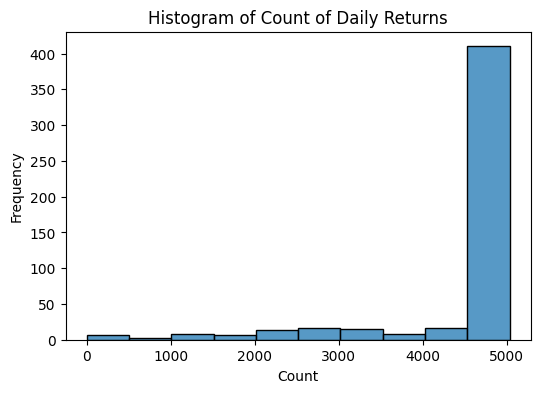

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(descriptive_data.loc['count'], bins=10, kde=False)
plt.title('Histogram of Count of Daily Returns')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Check if it's GEV and SOLV that have count = 0
daily_return_df[['GEV', 'SOLV']].describe()

,GEV,SOLV
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


GEV: Founded on April 2, 2024 \
SOLV: Spun off from 3M (and hence founded) on April 1, 2024

In [10]:
# Check for missing values
daily_return_df.isnull().sum()

MSFT        0
NVDA        0
AAPL        0
AMZN        0
META     2110
GOOGL     158
GOOG      158
BRK-B       0
LLY         0
AVGO     1408
JPM         0
XOM         0
TSLA     1633
UNH         0
V        1059
PG          0
COST        0
MA        603
JNJ         0
MRK         0
HD          0
ABBV     2265
WMT         0
NFLX        0
BAC         0
CVX         0
AMD         0
KO          0
CRM       118
QCOM        0
PEP         0
TMO         0
LIN         0
WFC         0
ADBE        0
ORCL        0
AMAT        0
DIS         0
ABT         0
CSCO        0
MCD         0
ACN         0
TXN         0
GE          0
DHR         0
VZ          0
CAT         0
AMGN        0
PM       1057
INTU        0
PFE         0
NEE         0
IBM         0
CMCSA       0
MU          0
GS          0
ISRG        0
NOW      2139
RTX         0
UBER     3864
UNP         0
HON         0
SPGI        0
COP         0
AXP         0
BKNG        0
LRCX        0
INTC        0
ETN         0
T           0
ELV         0
LOW   

In [11]:
daily_return_df['V'].describe()

count    3973.000000
mean        0.000933
std         0.018538
min        -0.136435
25%        -0.007761
50%         0.001216
75%         0.009264
max         0.149973
Name: V, dtype: float64

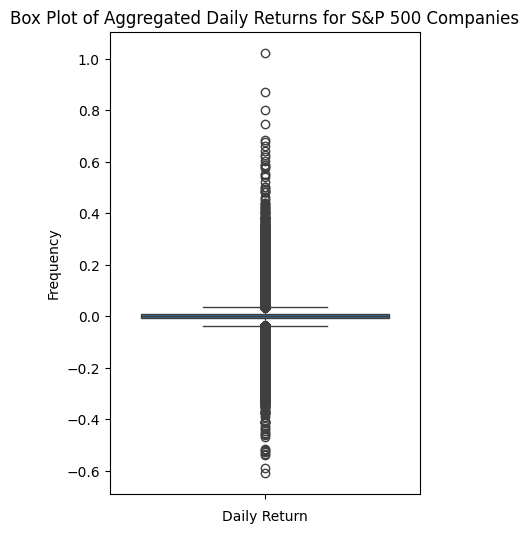

In [12]:
aggregated_return = daily_return_df.stack()

plt.figure(figsize=(4, 6))
sns.boxplot(aggregated_return)
plt.title('Box Plot of Aggregated Daily Returns for S&P 500 Companies')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

In [13]:
summary_statistics = aggregated_return.describe()
summary_statistics

count    2.310181e+06
mean     6.877896e-04
std      2.200777e-02
min     -6.079076e-01
25%     -8.543333e-03
50%      6.357621e-04
75%      9.852506e-03
max      1.023578e+00
dtype: float64

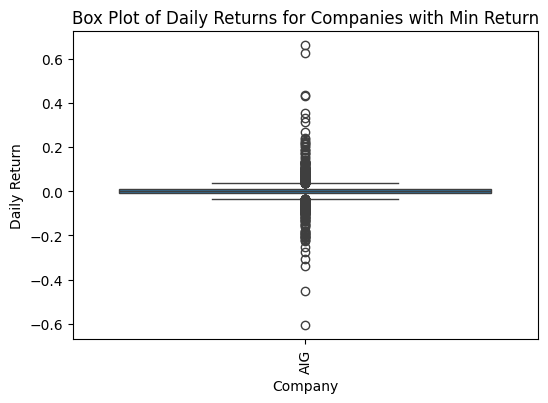

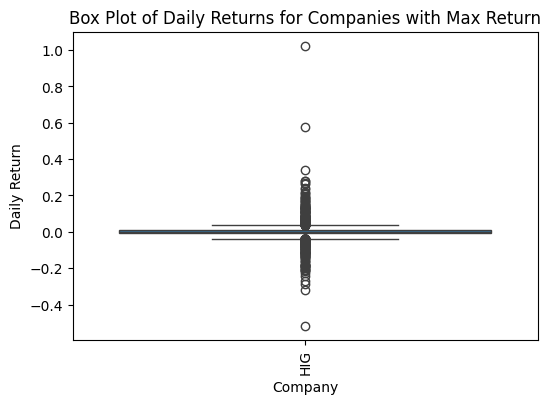

In [14]:
companies_min = daily_return_df.loc[:, (daily_return_df == summary_statistics['min']).any()].columns
companies_max = daily_return_df.loc[:, (daily_return_df == summary_statistics['max']).any()].columns

plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_min])
plt.title('Box Plot of Daily Returns for Companies with Min Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()
plt.figure(figsize=(6, 4))
sns.boxplot(daily_return_df[companies_max])
plt.title('Box Plot of Daily Returns for Companies with Max Return')
plt.xlabel('Company')
plt.ylabel('Daily Return')
plt.xticks(rotation=90)
plt.show()

In [15]:
daily_return_df.index[daily_return_df['AIG'] == summary_statistics['min']]

Index([2008-09-15 00:00:00-04:00], dtype='object', name='Date')

In [16]:
daily_return_df.index[daily_return_df['HIG'] == summary_statistics['max']]

Index([2008-12-05 00:00:00-05:00], dtype='object', name='Date')

<Figure size 2000x600 with 0 Axes>

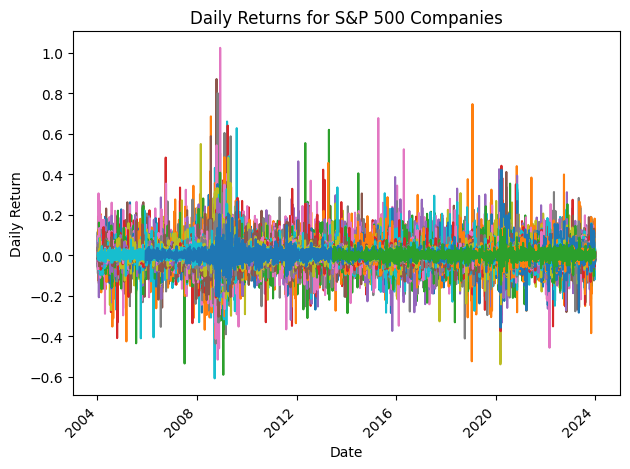

In [17]:
plt.figure(figsize=(20, 6))

daily_return_df.plot(legend=False)
plt.title('Daily Returns for S&P 500 Companies')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

AIG: American Internation Group Inc. \
AIG, a global company with about \$1 trillion in assets prior to the crisis, lost \$99.2 billion in 2008. On September 16 of that year, the Federal Reserve Bank of New York stepped in with an $85 billion loan to keep the failing company from going under.
https://insight.kellogg.northwestern.edu/article/what-went-wrong-at-aig#:~:text=AIG%2C%20a%20global%20company%20with,failing%20company%20from%20going%20under.
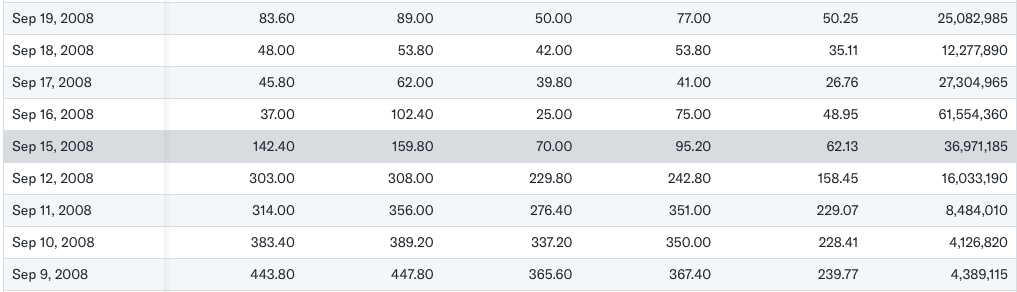

HIG: Hartford Financial Services Group Inc.
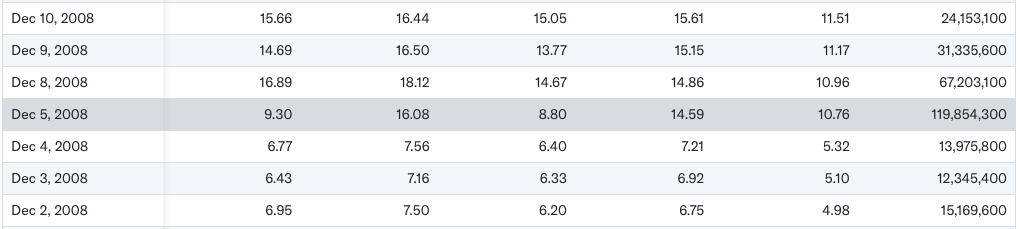

In [18]:
# AIG
(62.13-158.45)/158.45

-0.6078889239507731

In [19]:
# HIG
(10.76-5.32)/5.32

1.0225563909774436

In [20]:
# Drop stocks (columns, hence axis = 1) with null values within this 10-year period
daily_return_cleaned_df = daily_return_df.dropna(axis=1)
daily_return_cleaned_df.isnull().sum()

MSFT     0
NVDA     0
AAPL     0
AMZN     0
BRK-B    0
LLY      0
JPM      0
XOM      0
UNH      0
PG       0
COST     0
JNJ      0
MRK      0
HD       0
WMT      0
NFLX     0
BAC      0
CVX      0
AMD      0
KO       0
QCOM     0
PEP      0
TMO      0
LIN      0
WFC      0
ADBE     0
ORCL     0
AMAT     0
DIS      0
ABT      0
CSCO     0
MCD      0
ACN      0
TXN      0
GE       0
DHR      0
VZ       0
CAT      0
AMGN     0
INTU     0
PFE      0
NEE      0
IBM      0
CMCSA    0
MU       0
GS       0
ISRG     0
RTX      0
UNP      0
HON      0
SPGI     0
COP      0
AXP      0
BKNG     0
LRCX     0
INTC     0
ETN      0
T        0
ELV      0
LOW      0
VRTX     0
PGR      0
TJX      0
MS       0
SYK      0
C        0
NKE      0
ADI      0
BSX      0
MDT      0
SCHW     0
BA       0
CB       0
KLAC     0
BLK      0
REGN     0
MMC      0
PLD      0
ADP      0
LMT      0
UPS      0
CI       0
DE       0
SBUX     0
AMT      0
MDLZ     0
FI       0
SNPS     0
BMY      0
SO       0
MO       0

In [21]:
# See how many stocks are left after dropping stocks with null values
len(daily_return_cleaned_df.columns)

388

###**4. Get the correlation matrix**

In [57]:
correlation_matrix = daily_return_cleaned_df.corr()
correlation_matrix

,MSFT,NVDA,AAPL,AMZN,BRK-B,LLY,JPM,XOM,UNH,PG,...,HAS,FRT,GL,FMC,IVZ,RHI,BEN,CMA,MHK,BIO
MSFT,1.000000,0.511251,0.515875,0.513598,0.456936,0.397549,0.449748,0.413685,0.401533,0.443252,...,0.378758,0.383549,0.443545,0.448437,0.490187,0.427851,0.498522,0.346031,0.390501,0.400262
NVDA,0.511251,1.000000,0.457382,0.415434,0.353807,0.263925,0.355184,0.318554,0.293262,0.270191,...,0.310992,0.305423,0.355271,0.383705,0.427253,0.401016,0.424247,0.318181,0.353756,0.327366
AAPL,0.515875,0.457382,1.000000,0.445228,0.366614,0.290832,0.395235,0.342901,0.342861,0.333419,...,0.337765,0.332871,0.363539,0.399301,0.430848,0.381387,0.429874,0.321488,0.324032,0.335534
AMZN,0.513598,0.415434,0.445228,1.000000,0.331856,0.278473,0.347681,0.284270,0.288249,0.264903,...,0.313281,0.306893,0.308103,0.347220,0.393931,0.364061,0.414686,0.267742,0.321843,0.337587
BRK-B,0.456936,0.353807,0.366614,0.331856,1.000000,0.349592,0.595031,0.480735,0.403913,0.414461,...,0.376647,0.452802,0.602610,0.478225,0.566588,0.475415,0.564983,0.526861,0.471732,0.363027
LLY,0.397549,0.263925,0.290832,0.278473,0.349592,1.000000,0.350961,0.365668,0.406178,0.445079,...,0.247205,0.316569,0.410188,0.320416,0.371833,0.317108,0.394955,0.258896,0.272966,0.330183
JPM,0.449748,0.355184,0.395235,0.347681,0.595031,0.350961,1.000000,0.481011,0.395930,0.398159,...,0.398317,0.614223,0.702855,0.490698,0.676939,0.530010,0.677666,0.739665,0.506334,0.381235
XOM,0.413685,0.318554,0.342901,0.284270,0.480735,0.365668,0.481011,1.000000,0.386972,0.401538,...,0.355161,0.448093,0.514018,0.519236,0.518655,0.453874,0.527886,0.455412,0.384065,0.277691
UNH,0.401533,0.293262,0.342861,0.288249,0.403913,0.406178,0.395930,0.386972,1.000000,0.388405,...,0.282805,0.348915,0.422063,0.386874,0.402923,0.340061,0.412052,0.314734,0.325199,0.328292
PG,0.443252,0.270191,0.333419,0.264903,0.414461,0.445079,0.398159,0.401538,0.388405,1.000000,...,0.313981,0.376678,0.449834,0.356404,0.416589,0.343556,0.448645,0.304420,0.301606,0.329196


pandas.DataFrame.corr() here uses Pearson correlation coefficient.
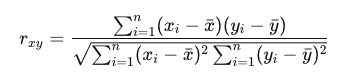

In [49]:
correlation_matrix[correlation_matrix < 0].stack()

Series([], dtype: float64)

###**5. Perform K-means clustering**

K-Means from Scikitlearn \

Default method of initialization of centroids: K-means++
1. Choose one center uniformly at random among the data points.
2. For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)^2.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering. \

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html \
https://en.wikipedia.org/wiki/K-means%2B%2B

In [23]:
import warnings
warnings.filterwarnings("ignore")

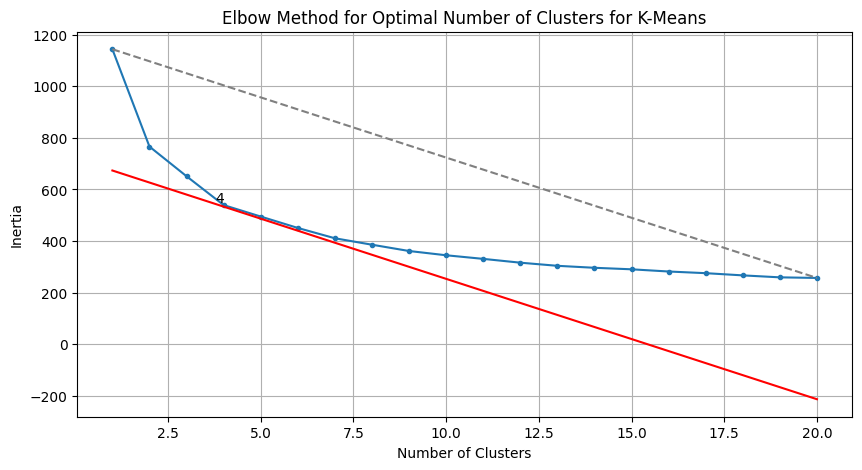

In [93]:
# Test out different values of n_clusters using the elbow method
# Try the numbers between 1 to 20
n_cluster_options = range(1, 21)

# inertia_: Sum of squared distances of samples to their closest cluster center
inertia_array = []

for n_cluster in n_cluster_options:
    kmeans = KMeans(n_clusters=n_cluster, random_state=123)
    kmeans.fit(correlation_matrix)
    inertia_array.append(kmeans.inertia_)

start_point = (n_cluster_options[0], inertia_array[0])
end_point = (n_cluster_options[-1], inertia_array[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(1, 20)
y_values = slope * x_values + 720

# Plot
plt.figure(figsize=(10, 5))
plt.plot(n_cluster_options, inertia_array, marker='.')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
plt.plot(x_values, y_values, color='red')

plt.text(n_cluster_options[3], inertia_array[3], f'{n_cluster_options[3]}', ha='right', va='bottom')

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters for K-Means')
plt.grid(True)
plt.show()

Based on the Elbow method graph above, it appears that 4 is the inflection point. We will proceed with n_cluster = 4 in our K-means algorithm.

In [64]:
# Perform K-means clustering with n_cluster = 4
kmeans = KMeans(n_clusters=4, random_state=123).fit(correlation_matrix)
kmeans_labels = kmeans.labels_

In [65]:
# Perform PCA with n_components = 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(correlation_matrix)

reduced_data.shape

(388, 2)

Text(0, 0.5, 'PCA Component 2')

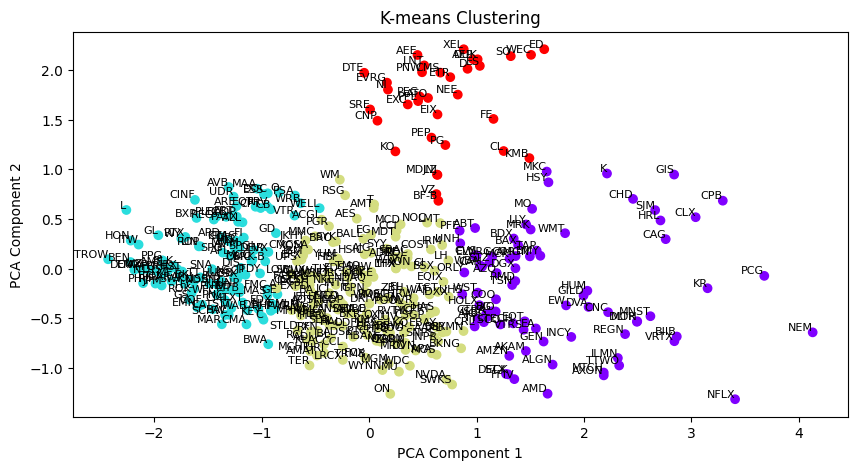

In [66]:
# Plot the K-means clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='rainbow')
for i, ticker in enumerate(correlation_matrix.columns):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], ticker, fontsize=8, ha='right', va='bottom')
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

####**5.1 Get industry sector data**

Obtained sector data from

*   https://www.barchart.com/stocks/indices/sp-sector/consumer-discretionary
*   https://www.spglobal.com/spdji/en/index-family/equity/us-equity/sp-sectors/#indices



In [67]:
industry_sector = pd.read_csv("https://raw.githubusercontent.com/Hyshubham2504/Clustering-Project/main/Industry.csv")
industry_sector.head()

,Ticker Symbol,Industry Sector
0,ABNB,Consumer Discretionary
1,AMZN,Consumer Discretionary
2,APTV,Consumer Discretionary
3,AZO,Consumer Discretionary
4,BBWI,Consumer Discretionary


In [68]:
# Create a dataframe with Ticker, Cluster (that the Ticker is assigned to), and Industry Sector as columns
ticker_cluster_df = pd.DataFrame({
    'Ticker Symbol': correlation_matrix.columns,
    'Cluster': kmeans_labels
})

ticker_cluster_sector_df = pd.merge(ticker_cluster_df, industry_sector, on='Ticker Symbol', how='left')
ticker_cluster_sector_df

,Ticker Symbol,Cluster,Industry Sector
0,MSFT,2,Information Technology
1,NVDA,2,Information Technology
2,AAPL,2,Information Technology
3,AMZN,0,Consumer Discretionary
4,BRK-B,1,Financials
5,LLY,0,Health Care
6,JPM,1,Financials
7,XOM,2,Energy
8,UNH,0,Health Care
9,PG,3,Customer Staples


In [69]:
# Check if there is any ticker symbols that do not have Industry_Sector
ticker_cluster_sector_df[ticker_cluster_sector_df['Industry Sector'].isnull()]

,Ticker Symbol,Cluster,Industry Sector


In [70]:
# Check the number of tickers that fall into each industry sector among these 388 tickers
ticker_cluster_sector_df['Industry Sector'].value_counts()

Industry Sector
Financials                57
Industrials               57
Health Care               54
Information Technology    48
Consumer Discretionary    38
Customer Staples          32
Utilities                 28
Real Estate               26
Materials                 21
Energy                    17
Communication Services    10
Name: count, dtype: int64

In [71]:
# Same as above, but in percentage
ticker_cluster_sector_df['Industry Sector'].value_counts(normalize=True)*100

Industry Sector
Financials                14.690722
Industrials               14.690722
Health Care               13.917526
Information Technology    12.371134
Consumer Discretionary     9.793814
Customer Staples           8.247423
Utilities                  7.216495
Real Estate                6.701031
Materials                  5.412371
Energy                     4.381443
Communication Services     2.577320
Name: proportion, dtype: float64

In [72]:
# Check the percentage of industry sectors in each cluster
sector_count_df = ticker_cluster_sector_df.groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
sector_count_df

Industry Sector,Communication Services,Consumer Discretionary,Customer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
Cluster,,,,,,,,,,,
0,4,5,20,2,1,37,1,6,1,0,2
1,2,4,0,1,38,1,35,3,10,20,0
2,3,29,5,14,18,15,21,39,10,6,1
3,1,0,7,0,0,1,0,0,0,0,25


In [73]:
# See the total number of ticker symbols in each cluster
total_cluster_count = sector_count_df.sum(axis=1)
total_cluster_count

Cluster
0     79
1    114
2    161
3     34
dtype: int64

In [74]:
# Find the percentage of industry sectors in each cluster
sector_percentage_df = sector_count_df.div(total_cluster_count, axis=0)*100
sector_percentage_df

Industry Sector,Communication Services,Consumer Discretionary,Customer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
Cluster,,,,,,,,,,,
0,5.063291,6.329114,25.316456,2.531646,1.265823,46.835443,1.265823,7.594937,1.265823,0.000000,2.531646
1,1.754386,3.508772,0.000000,0.877193,33.333333,0.877193,30.701754,2.631579,8.771930,17.543860,0.000000
2,1.863354,18.012422,3.105590,8.695652,11.180124,9.316770,13.043478,24.223602,6.211180,3.726708,0.621118
3,2.941176,0.000000,20.588235,0.000000,0.000000,2.941176,0.000000,0.000000,0.000000,0.000000,73.529412


In [75]:
for cluster in sector_percentage_df.index:
    print(f"Cluster {cluster}:")

    sorted_sectors = sector_percentage_df.loc[cluster].sort_values(ascending=False)

    for sector, percentage in sorted_sectors.items():
        print(f"  {sector}: {percentage:.2f}%")

    print("\n")

Cluster 0:
  Health Care: 46.84%
  Customer Staples: 25.32%
  Information Technology: 7.59%
  Consumer Discretionary: 6.33%
  Communication Services: 5.06%
  Energy: 2.53%
  Utilities: 2.53%
  Financials: 1.27%
  Industrials: 1.27%
  Materials: 1.27%
  Real Estate: 0.00%


Cluster 1:
  Financials: 33.33%
  Industrials: 30.70%
  Real Estate: 17.54%
  Materials: 8.77%
  Consumer Discretionary: 3.51%
  Information Technology: 2.63%
  Communication Services: 1.75%
  Energy: 0.88%
  Health Care: 0.88%
  Customer Staples: 0.00%
  Utilities: 0.00%


Cluster 2:
  Information Technology: 24.22%
  Consumer Discretionary: 18.01%
  Industrials: 13.04%
  Financials: 11.18%
  Health Care: 9.32%
  Energy: 8.70%
  Materials: 6.21%
  Real Estate: 3.73%
  Customer Staples: 3.11%
  Communication Services: 1.86%
  Utilities: 0.62%


Cluster 3:
  Utilities: 73.53%
  Customer Staples: 20.59%
  Communication Services: 2.94%
  Health Care: 2.94%
  Consumer Discretionary: 0.00%
  Energy: 0.00%
  Financials: 0.

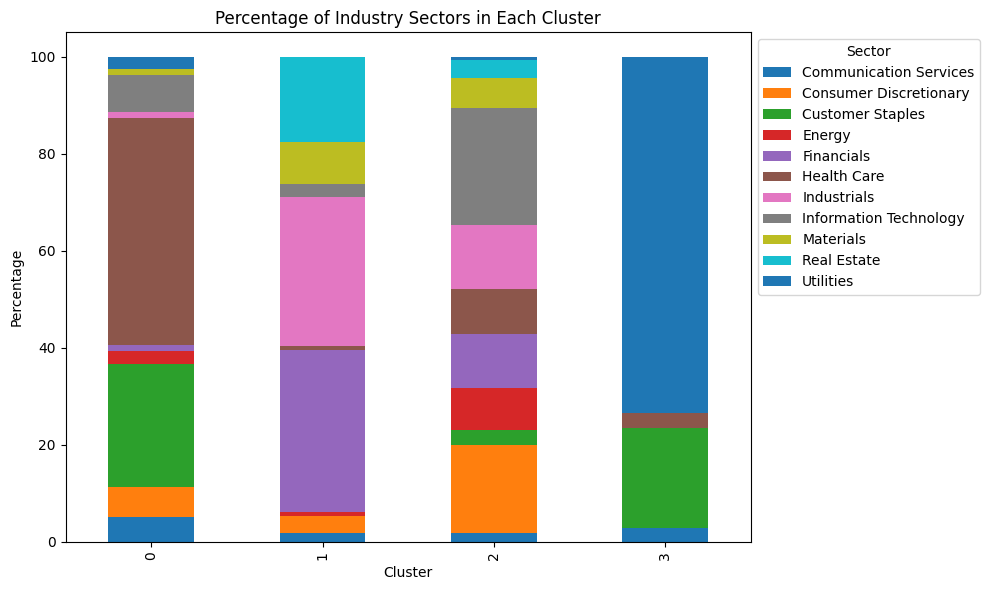

In [37]:
# Stacked bar chart
sector_percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of Industry Sectors in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [76]:
# Plot the K-means scatterplot again, but only label the top 3 companies in each sector by index weight
# https://www.spglobal.com/spdji/en/index-family/equity/us-equity/sp-sectors/#indices
# https://www.slickcharts.com/sp500
communication = ['NFLX', 'DIS', 'VZ']
cons_disc = ['AMZN', 'HD', 'MCD']
cons_staples = ['PG', 'COST', 'WMT']
energy = ['XOM', 'CVX', 'COP']
financials = ['BRK-B', 'JPM', 'BAC']
health_care = ['LLY', 'UNH', 'JNJ']
industrials = ['GE', 'CAT', 'RTX']
info_tech = ['MSFT', 'NVDA', 'AAPL']
materials = ['LIN', 'FCX', 'SHW']
real_estate = ['PLD', 'AMT', 'EQIX']
utilities = ['NEE', 'SO', 'DUK']

top_tickers_category = ['Communication services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']
top_tickers = [communication, cons_disc, cons_staples, energy, financials, health_care, industrials, info_tech, materials, real_estate, utilities]

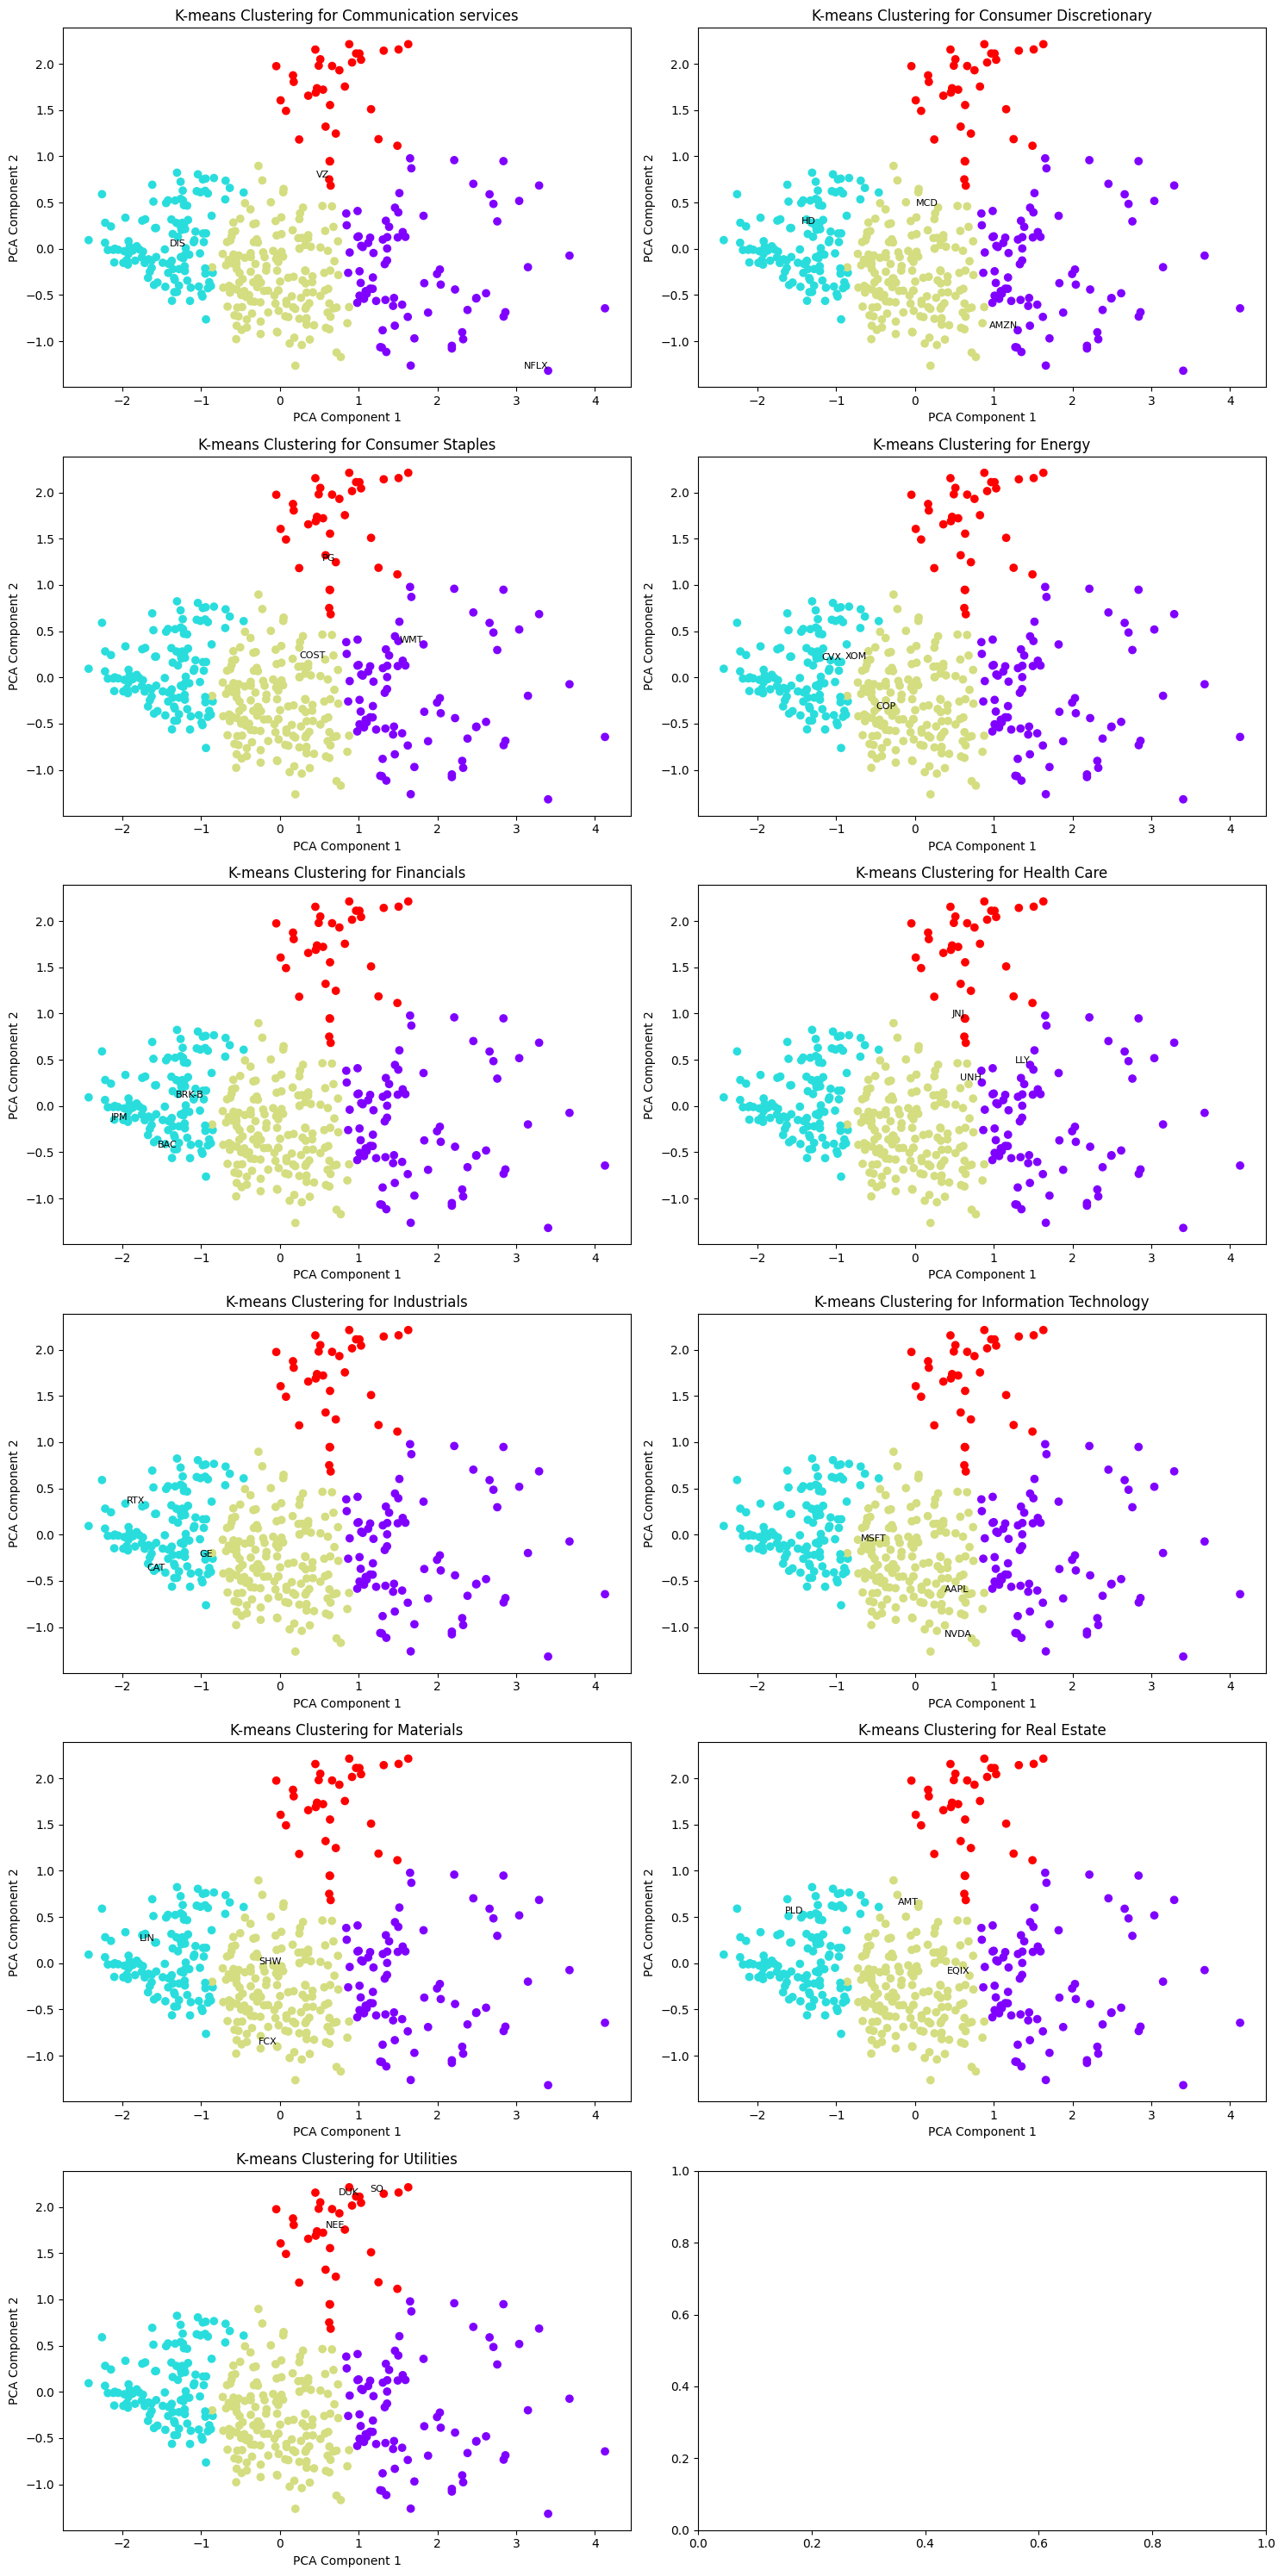

In [77]:
figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()

for i, (top_ticker_list, ax) in enumerate(zip(top_tickers, axis)):
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='rainbow')
    for j, ticker in enumerate(correlation_matrix.columns):
        if ticker in top_ticker_list:
            # Locate the index for the ticker in the reduced data
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            ax.text(reduced_data[ticker_index, 0], reduced_data[ticker_index, 1], ticker,
                    fontsize=8, ha='right', va='bottom')
    ax.set_title(f'K-means Clustering for {top_tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

###**6. Perform hierarchical clustering**
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering \

https://jbhender.github.io/Stats506/F18/GP/Group15.html

In [118]:
def wss_calculation(K, data):
    WSS = []
    for i in range(K):
        cluster = AgglomerativeClustering(n_clusters=i + 1)
        labels = cluster.fit_predict(data)
        wss = []
        for j in range(i + 1):
            # extract each cluster according to its index
            cluster_data = data[labels == j]
            cluster_mean = cluster_data.mean(axis=0)
            distance = np.sum(np.square(cluster_data - cluster_mean))
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

In [123]:
WSS = wss_calculation(20, correlation_matrix)

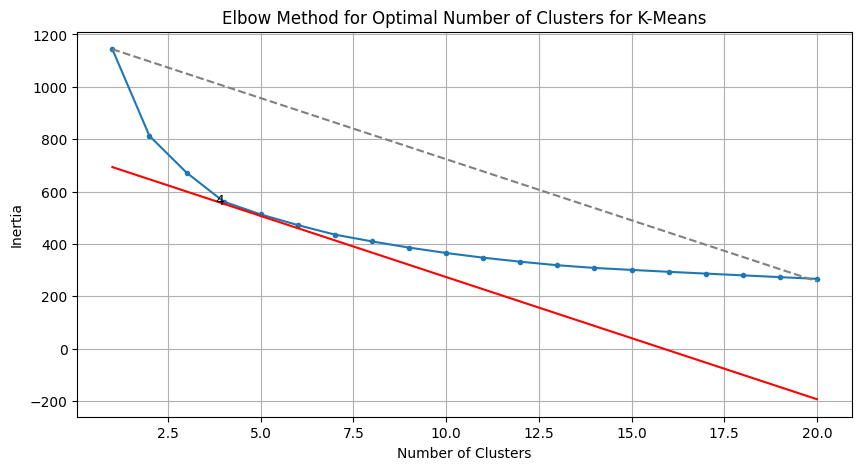

In [130]:
n_cluster_options = range(1, 21)

start_point = (n_cluster_options[0], inertia_array[0])
end_point = (n_cluster_options[-1], inertia_array[-1])
slope = (end_point[1] - start_point[1]) / (end_point[0] - start_point[0])

x_values = np.linspace(1, 20)
y_values = slope * x_values + 740

# Plot
plt.figure(figsize=(10, 5))
plt.plot(n_cluster_options, WSS, marker='.')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], linestyle='--', color='gray')
plt.plot(x_values, y_values, color='red')

plt.text(n_cluster_options[3], inertia_array[3], f'{n_cluster_options[3]}', ha='right', va='bottom')

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters for K-Means')
plt.grid(True)
plt.show()

Based on the Elbow method graph above, it appears that 4 is the inflection point. We will proceed with n_cluster = 4 in our hierarchical clustering algorithm.

In [132]:
hierarchical_clustering = AgglomerativeClustering(n_clusters = 4).fit(correlation_matrix)
hierarchical_labels = hierarchical_clustering.labels_

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(correlation_matrix)

Text(0, 0.5, 'PCA Component 2')

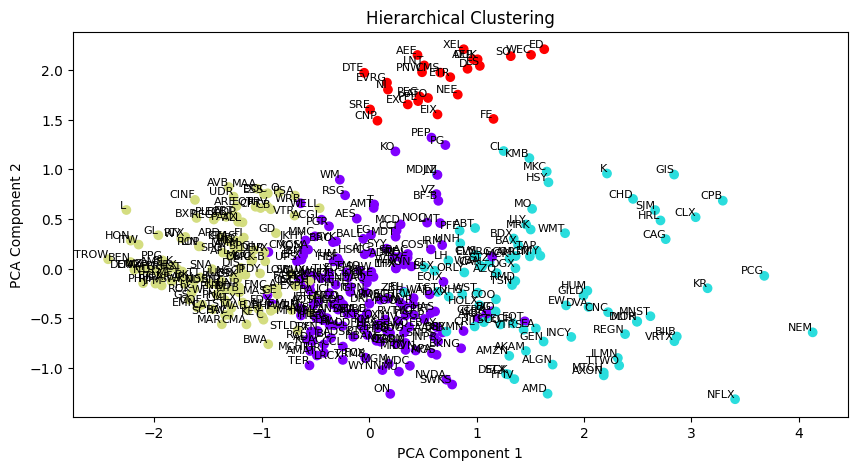

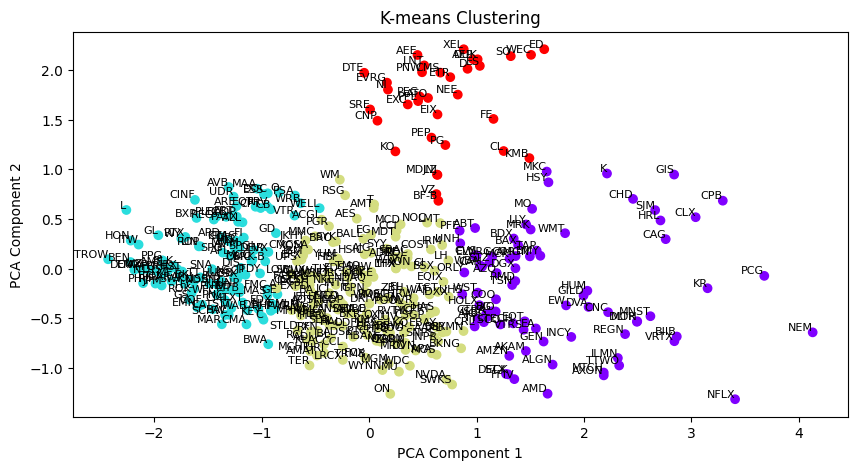

In [135]:
# Plot the hierarchical clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hierarchical_labels, cmap='rainbow')
for i, ticker in enumerate(correlation_matrix.columns):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], ticker, fontsize=8, ha='right', va='bottom')
plt.title('Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot the K-means clusters
plt.figure(figsize=(10, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='rainbow')
for i, ticker in enumerate(correlation_matrix.columns):
    plt.text(reduced_data[i, 0], reduced_data[i, 1], ticker, fontsize=8, ha='right', va='bottom')
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

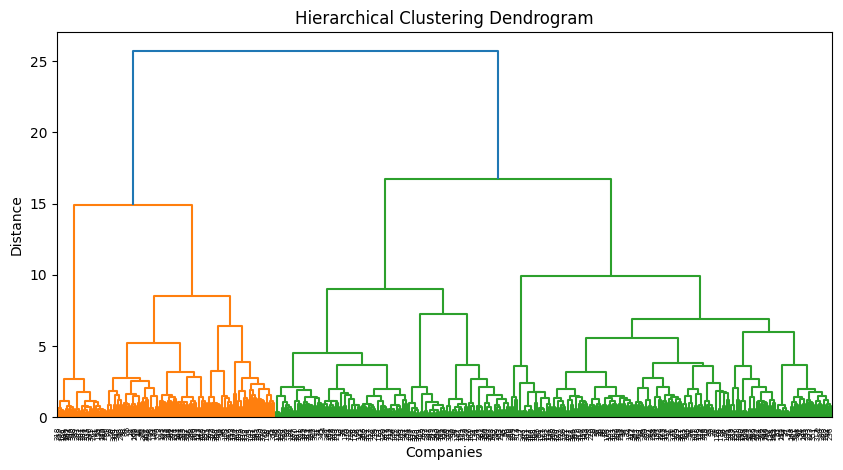

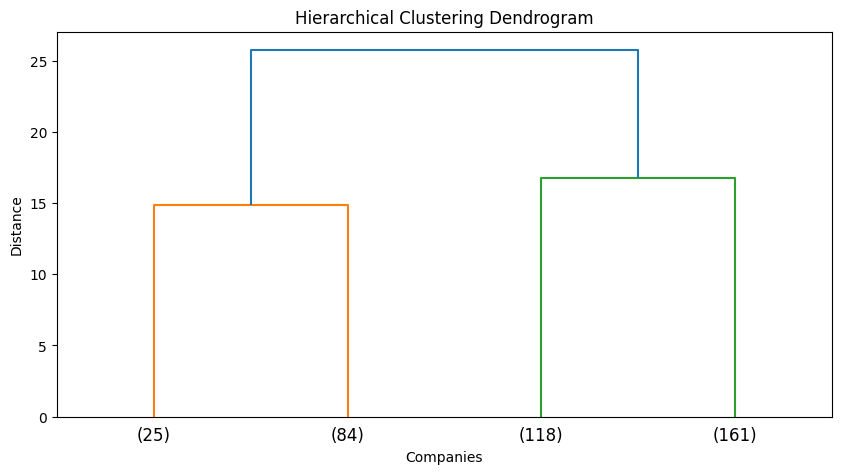

In [140]:
link = linkage(correlation_matrix, method='ward')  #AgglomerativeClustering from scikitlearn uses linkage=ward by default, so use ward here as well

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(link)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 5))
dendrogram(link, truncate_mode='lastp', p=4)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Companies')
plt.ylabel('Distance')
plt.show()

####**6.1 Get industry sector data**

In [141]:
# Create a dataframe with Ticker, Cluster (that the Ticker is assigned to), and Industry Sector as columns
ticker_cluster_df_hierarchical = pd.DataFrame({
    'Ticker Symbol': correlation_matrix.columns,
    'Cluster': hierarchical_labels
})

ticker_cluster_sector_df_hierarchical = pd.merge(ticker_cluster_df_hierarchical, industry_sector, on='Ticker Symbol', how='left')
ticker_cluster_sector_df_hierarchical

,Ticker Symbol,Cluster,Industry Sector
0,MSFT,0,Information Technology
1,NVDA,0,Information Technology
2,AAPL,0,Information Technology
3,AMZN,1,Consumer Discretionary
4,BRK-B,2,Financials
5,LLY,1,Health Care
6,JPM,2,Financials
7,XOM,0,Energy
8,UNH,1,Health Care
9,PG,0,Customer Staples


In [143]:
# Check if there is any ticker symbols that do not have Industry_Sector
ticker_cluster_sector_df_hierarchical[ticker_cluster_sector_df_hierarchical['Industry Sector'].isnull()]

,Ticker Symbol,Cluster,Industry Sector


In [144]:
# Check the number of tickers that fall into each industry sector among these 388 tickers
ticker_cluster_sector_df_hierarchical['Industry Sector'].value_counts()

Industry Sector
Financials                57
Industrials               57
Health Care               54
Information Technology    48
Consumer Discretionary    38
Customer Staples          32
Utilities                 28
Real Estate               26
Materials                 21
Energy                    17
Communication Services    10
Name: count, dtype: int64

In [145]:
# Same as above, but in percentage
ticker_cluster_sector_df_hierarchical['Industry Sector'].value_counts(normalize=True)*100

Industry Sector
Financials                14.690722
Industrials               14.690722
Health Care               13.917526
Information Technology    12.371134
Consumer Discretionary     9.793814
Customer Staples           8.247423
Utilities                  7.216495
Real Estate                6.701031
Materials                  5.412371
Energy                     4.381443
Communication Services     2.577320
Name: proportion, dtype: float64

In [146]:
# Check the percentage of industry sectors in each cluster
sector_count_df_hierarchical = ticker_cluster_sector_df_hierarchical.groupby(['Cluster', 'Industry Sector']).size().unstack(fill_value=0)
sector_count_df_hierarchical

Industry Sector,Communication Services,Consumer Discretionary,Customer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
Cluster,,,,,,,,,,,
0,3,27,10,17,20,9,21,39,7,6,2
1,4,6,22,0,0,43,1,6,1,0,1
2,3,5,0,0,37,2,35,3,13,20,0
3,0,0,0,0,0,0,0,0,0,0,25


In [147]:
# See the total number of ticker symbols in each cluster
total_cluster_count_hierarchical = sector_count_df_hierarchical.sum(axis=1)
total_cluster_count_hierarchical

Cluster
0    161
1     84
2    118
3     25
dtype: int64

In [148]:
# Find the percentage of industry sectors in each cluster
sector_percentage_df_hierarchical = sector_count_df_hierarchical.div(total_cluster_count_hierarchical, axis=0)*100
sector_percentage_df_hierarchical

Industry Sector,Communication Services,Consumer Discretionary,Customer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
Cluster,,,,,,,,,,,
0,1.863354,16.770186,6.211180,10.559006,12.422360,5.590062,13.043478,24.223602,4.347826,3.726708,1.242236
1,4.761905,7.142857,26.190476,0.000000,0.000000,51.190476,1.190476,7.142857,1.190476,0.000000,1.190476
2,2.542373,4.237288,0.000000,0.000000,31.355932,1.694915,29.661017,2.542373,11.016949,16.949153,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000


In [149]:
for cluster in sector_percentage_df_hierarchical.index:
    print(f"Cluster {cluster}:")

    sorted_sectors_hierarchical = sector_percentage_df_hierarchical.loc[cluster].sort_values(ascending=False)

    for sector, percentage in sorted_sectors_hierarchical.items():
        print(f"  {sector}: {percentage:.2f}%")

    print("\n")

Cluster 0:
  Information Technology: 24.22%
  Consumer Discretionary: 16.77%
  Industrials: 13.04%
  Financials: 12.42%
  Energy: 10.56%
  Customer Staples: 6.21%
  Health Care: 5.59%
  Materials: 4.35%
  Real Estate: 3.73%
  Communication Services: 1.86%
  Utilities: 1.24%


Cluster 1:
  Health Care: 51.19%
  Customer Staples: 26.19%
  Consumer Discretionary: 7.14%
  Information Technology: 7.14%
  Communication Services: 4.76%
  Industrials: 1.19%
  Materials: 1.19%
  Utilities: 1.19%
  Energy: 0.00%
  Financials: 0.00%
  Real Estate: 0.00%


Cluster 2:
  Financials: 31.36%
  Industrials: 29.66%
  Real Estate: 16.95%
  Materials: 11.02%
  Consumer Discretionary: 4.24%
  Communication Services: 2.54%
  Information Technology: 2.54%
  Health Care: 1.69%
  Customer Staples: 0.00%
  Energy: 0.00%
  Utilities: 0.00%


Cluster 3:
  Utilities: 100.00%
  Communication Services: 0.00%
  Consumer Discretionary: 0.00%
  Customer Staples: 0.00%
  Energy: 0.00%
  Financials: 0.00%
  Health Care: 

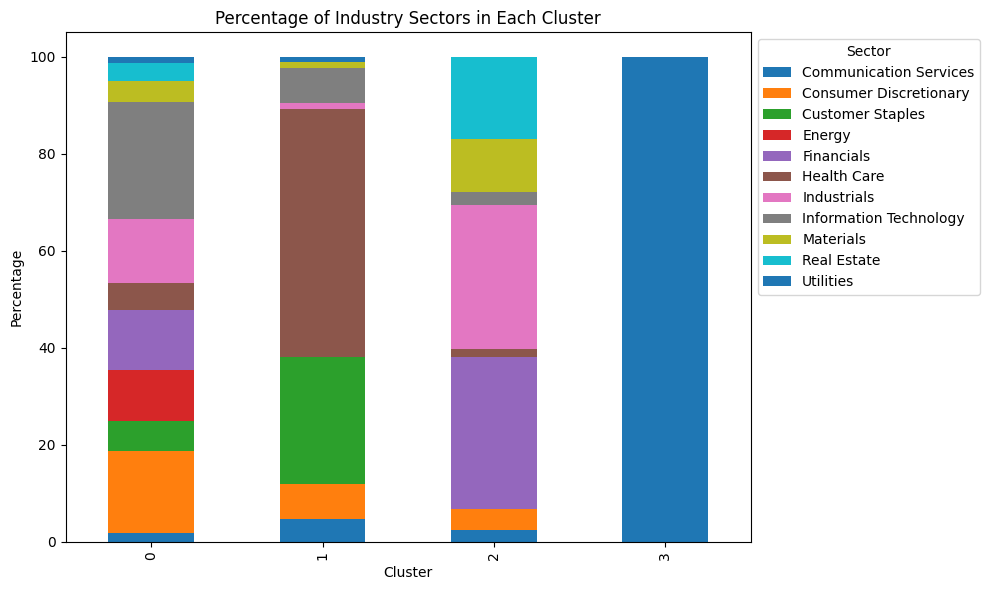

In [150]:
# Stacked bar chart
sector_percentage_df_hierarchical.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of Industry Sectors in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Sector', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

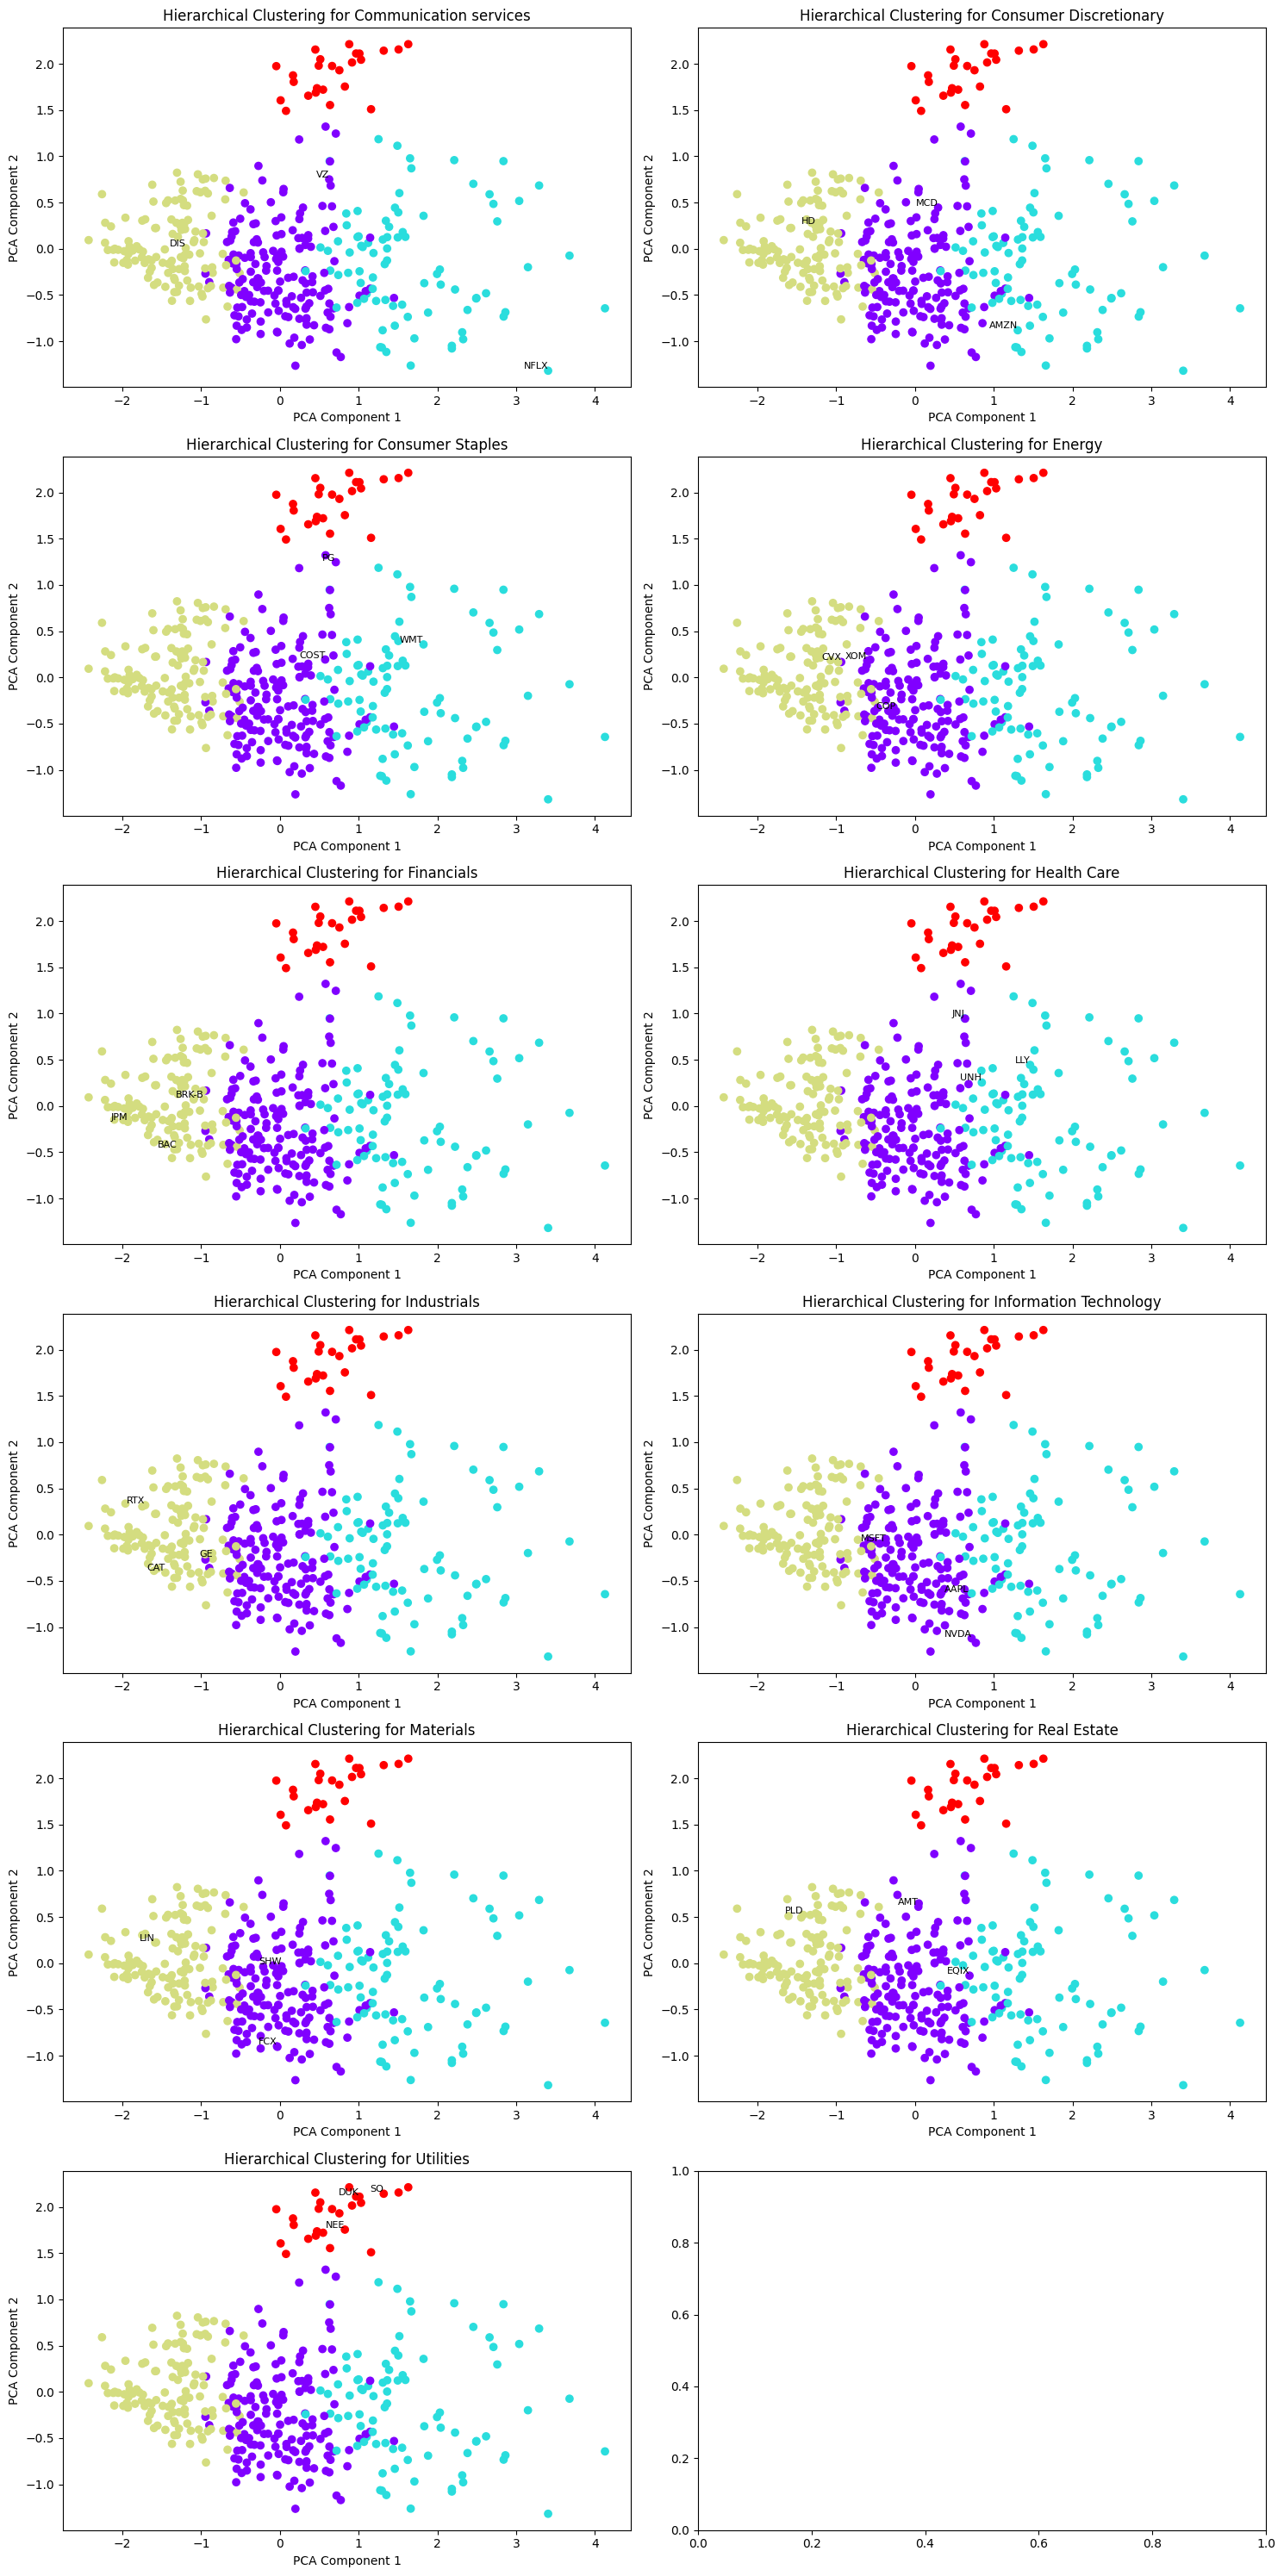

In [151]:
figure, axis = plt.subplots(6, 2, figsize=(15, 30))
axis = axis.flatten()

for i, (top_ticker_list, ax) in enumerate(zip(top_tickers, axis)):
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hierarchical_labels, cmap='rainbow')
    for j, ticker in enumerate(correlation_matrix.columns):
        if ticker in top_ticker_list:
            # Locate the index for the ticker in the reduced data
            ticker_index = correlation_matrix.columns.get_loc(ticker)
            ax.text(reduced_data[ticker_index, 0], reduced_data[ticker_index, 1], ticker,
                    fontsize=8, ha='right', va='bottom')
    ax.set_title(f'Hierarchical Clustering for {top_tickers_category[i]}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()